Iteration 9: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, episode=500, returns=-320.800]


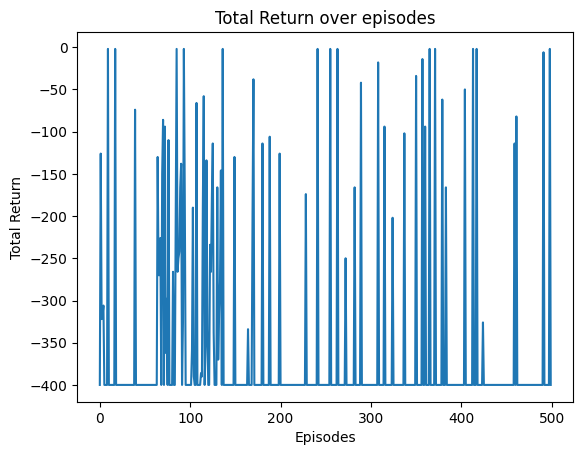

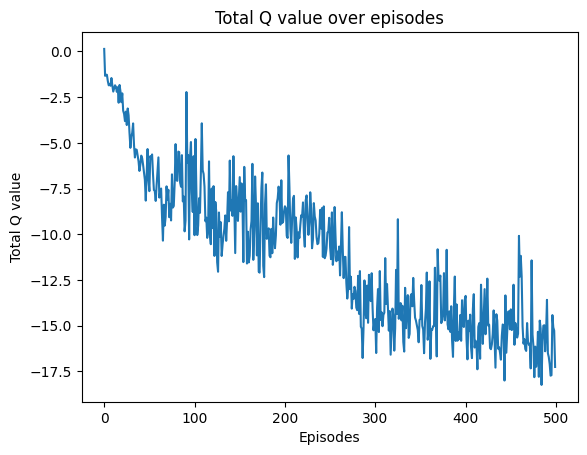

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from env.custom_environment import CustomEnvironment
from env.demo_env import SimpleTagEnvironment
from tqdm import tqdm

# Replay Buffer定义
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


# QMIX网络定义
class QMixNet(nn.Module):
    def __init__(self, args):
        super(QMixNet, self).__init__()
        self.args = args

        if args.two_hyper_layers:
            self.hyper_w1 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.n_agents * args.qmix_hidden_dim))
            self.hyper_w2 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.hyper_hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(args.hyper_hidden_dim, args.qmix_hidden_dim * 1))
        else:
            self.hyper_w1 = nn.Linear(args.state_shape * args.n_agents, args.n_agents * args.qmix_hidden_dim)
            self.hyper_w2 = nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim * 1)

        self.hyper_b1 = nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim)
        self.hyper_b2 = nn.Sequential(nn.Linear(args.state_shape * args.n_agents, args.qmix_hidden_dim),
                                      nn.ReLU(),
                                      nn.Linear(args.qmix_hidden_dim, 1))

    def forward(self, q_values, states):
        episode_num = q_values.size(0)
        q_values = q_values.view(episode_num, 1, self.args.n_agents)
        states = states.view(episode_num, -1)

        w1 = torch.abs(self.hyper_w1(states))
        b1 = self.hyper_b1(states)
        w1 = w1.view(episode_num, self.args.n_agents, self.args.qmix_hidden_dim)
        b1 = b1.view(episode_num, 1, self.args.qmix_hidden_dim)

        hidden = F.elu(torch.bmm(q_values, w1) + b1)
        w2 = torch.abs(self.hyper_w2(states))
        b2 = self.hyper_b2(states)
        w2 = w2.view(episode_num, self.args.qmix_hidden_dim, 1)
        b2 = b2.view(episode_num, 1, 1)

        q_total = torch.bmm(hidden, w2) + b2
        q_total = q_total.view(episode_num, -1, 1)
        return q_total


# RNN定义
class RNN(nn.Module):
    def __init__(self, input_shape, args):
        super(RNN, self).__init__()
        self.args = args
        self.fc1 = nn.Linear(input_shape, args.rnn_hidden_dim)
        self.rnn = nn.GRUCell(args.rnn_hidden_dim, args.rnn_hidden_dim)
        self.fc2 = nn.Linear(args.rnn_hidden_dim, args.n_actions)

    def forward(self, obs, hidden_state):
        x = F.relu(self.fc1(obs))
        h_in = hidden_state.reshape(-1, self.args.rnn_hidden_dim)
        h = self.rnn(x, h_in)
        q = self.fc2(h)
        return q, h


class QMIX:
    def __init__(self, env, args, use_cuda=False):
        self.env = env
        self.args = args
        self.use_cuda = use_cuda
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.replay_buffer = ReplayBuffer(args.buffer_size)
        self.rnn = RNN(args.obs_shape, args).to(self.device)
        self.qmix_net = QMixNet(args).to(self.device)
        self.optimizer = Adam(list(self.rnn.parameters()) + list(self.qmix_net.parameters()), lr=args.lr)
        self.loss_fn = nn.MSELoss()

    def choose_action(self, obs, hidden_state, epsilon=0.01):
        actions = {}
        new_hidden_state = {}

        for agent in self.env.agents:
            agent_obs = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
            agent_hidden_state = torch.tensor(hidden_state[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
            q_values, new_agent_hidden_state = self.rnn(agent_obs, agent_hidden_state)
            
            if random.random() < epsilon:
                action = random.choice(range(self.args.n_actions))  # 以 ε 的概率随机选择动作
            else:
                action = q_values.argmax(dim=-1).item()  # 以 1-ε 的概率选择 Q 值最大的动作
                
            actions[agent] = action
            new_hidden_state[agent] = new_agent_hidden_state.detach().cpu().numpy()

        return actions, new_hidden_state

    '''def train(self):
        if len(self.replay_buffer) < self.args.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.args.batch_size)
        states = {agent: torch.tensor([s[agent] for s in states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        actions = {agent: torch.tensor([a[agent] for a in actions], dtype=torch.int64).to(self.device) for agent in self.env.agents}
        rewards = {agent: torch.tensor([r[agent] for r in rewards], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_states = {agent: torch.tensor([ns[agent] for ns in next_states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        dones = {agent: torch.tensor([d[agent] for d in dones], dtype=torch.float32).to(self.device) for agent in self.env.agents}

        hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}

        q_values = {agent: self.rnn(states[agent], hidden_state[agent])[0].gather(1, actions[agent].unsqueeze(-1)).squeeze(-1) for agent in self.env.agents}
        next_q_values = {agent: self.rnn(next_states[agent], next_hidden_state[agent])[0].max(dim=-1)[0] for agent in self.env.agents}

        targets = {agent: rewards[agent] + self.args.gamma * next_q_values[agent] * (1 - dones[agent]) for agent in self.env.agents}

        q_values_tensor = torch.stack(list(q_values.values()), dim=1)
        targets_tensor = torch.stack(list(targets.values()), dim=1)
        states_tensor = torch.cat([states[agent].view(self.args.batch_size, -1) for agent in self.env.agents], dim=1)

        q_total = self.qmix_net(q_values_tensor, states_tensor)
        targets_total = self.qmix_net(targets_tensor, states_tensor)

        loss = self.loss_fn(q_total, targets_total.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()'''
    
    def train(self):
        '''if len(self.replay_buffer) < self.args.minimal_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.args.batch_size)
        states = {agent: torch.tensor([s[agent] for s in states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        actions = {agent: torch.tensor([a[agent] for a in actions], dtype=torch.int64).to(self.device) for agent in self.env.agents}
        rewards = {agent: torch.tensor([r[agent] for r in rewards], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_states = {agent: torch.tensor([ns[agent] for ns in next_states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
        dones = {agent: torch.tensor([d[agent] for d in dones], dtype=torch.float32).to(self.device) for agent in self.env.agents}'''
        if len(self.replay_buffer) < self.args.minimal_size:
            # 如果缓冲区中的数据小于 minimal_size，进行随机采样
            states = {agent: torch.tensor(np.random.randn(self.args.batch_size, self.args.obs_shape), dtype=torch.float32).to(self.device) for agent in self.env.agents}
            actions = {agent: torch.tensor(np.random.randint(self.args.n_actions, size=self.args.batch_size), dtype=torch.int64).to(self.device) for agent in self.env.agents}
            rewards = {agent: torch.tensor(np.random.randn(self.args.batch_size), dtype=torch.float32).to(self.device) for agent in self.env.agents}
            next_states = {agent: torch.tensor(np.random.randn(self.args.batch_size, self.args.obs_shape), dtype=torch.float32).to(self.device) for agent in self.env.agents}
            dones = {agent: torch.tensor(np.random.randint(2, size=self.args.batch_size), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        else:
            # 从经验回放缓冲区中采样
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.args.batch_size)
            states = {agent: torch.tensor([s[agent] for s in states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
            actions = {agent: torch.tensor([a[agent] for a in actions], dtype=torch.int64).to(self.device) for agent in self.env.agents}
            rewards = {agent: torch.tensor([r[agent] for r in rewards], dtype=torch.float32).to(self.device) for agent in self.env.agents}
            next_states = {agent: torch.tensor([ns[agent] for ns in next_states], dtype=torch.float32).to(self.device) for agent in self.env.agents}
            dones = {agent: torch.tensor([d[agent] for d in dones], dtype=torch.float32).to(self.device) for agent in self.env.agents}

        hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}
        next_hidden_state = {agent: torch.zeros((self.args.batch_size, self.args.rnn_hidden_dim), dtype=torch.float32).to(self.device) for agent in self.env.agents}

        q_values = {agent: self.rnn(states[agent], hidden_state[agent])[0].gather(1, actions[agent].unsqueeze(-1)).squeeze(-1) for agent in self.env.agents}
        next_q_values = {agent: self.rnn(next_states[agent], next_hidden_state[agent])[0].max(dim=-1)[0] for agent in self.env.agents}

        targets = {agent: rewards[agent] + self.args.gamma * next_q_values[agent] * (1 - dones[agent]) for agent in self.env.agents}

        q_values_tensor = torch.stack(list(q_values.values()), dim=1)
        targets_tensor = torch.stack(list(targets.values()), dim=1)
        states_tensor = torch.cat([states[agent].view(self.args.batch_size, -1) for agent in self.env.agents], dim=1)

        q_total = self.qmix_net(q_values_tensor, states_tensor)
        targets_total = self.qmix_net(targets_tensor, states_tensor)

        loss = self.loss_fn(q_total, targets_total.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
    def run(self, num_episodes):
        total_q_values = []
        total_returns = []

        for i in range(10):
            with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
                for episode in range(int(num_episodes / 10)):
                    obs = self.env.reset()  # 重置环境，获取初始观测
                    hidden_state = {agent: np.zeros(self.args.rnn_hidden_dim) for agent in self.env.agents}  # 初始化每个智能体的隐藏状态
                    episode_q_values = []
                    episode_return = 0
                    actions_over_time = []

                    for t in range(int(self.args.num_iterations)):
                        actions, hidden_state = self.choose_action(obs, hidden_state)
                        next_obs, rewards, dones, _ = self.env.step(actions)
                        self.replay_buffer.add((obs, actions, rewards, next_obs, dones))
                        obs = next_obs

                        actions_over_time.append(actions)

                        q_values = []
                        for agent in self.env.agents:
                            agent_obs = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
                            agent_hidden_state = torch.tensor(hidden_state[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
                            agent_q_values, _ = self.rnn(agent_obs, agent_hidden_state)
                            q_values.append(agent_q_values.max().item())
                        episode_q_values.append(np.mean(q_values))

                        episode_return += sum(rewards.values())

                        self.train()

                        if all(dones.values()):
                            break

                    total_q_values.append(np.mean(episode_q_values))
                    total_returns.append(episode_return)

                    '''if episode_return > 6000:
                        print(f"Episode {episode + 1} reached a total return of {episode_return}")
                        for t, actions in enumerate(actions_over_time):
                            print(f"Time step {t}:")
                            for agent, action in actions.items():
                                print(f"  Agent {agent}: Action {action}")'''
                    #print(episode_return)
                    if episode_return > 15000:
                        print(f"Episode {episode + 1} reached a total return of {episode_return}")
                        for t, actions in enumerate(actions_over_time):
                            #print(f"Time step {t}:")
                            actions_list = [actions[agent] for agent in self.env.agents]
                            print(actions_list)
                        print("done")
                    if (episode + 1) % 10 == 0:
                        pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + episode + 1), 'returns': '%.3f' % np.mean(total_returns[-10:])})
                    pbar.update(1)

        return total_q_values, total_returns
        
        
        
        
    def run1(self, num_episodes):
        total_q_values = []
        total_returns = []

        for i in range(10):
            with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
                for episode in range(int(num_episodes / 10)):
                    obs = self.env.reset()  # 重置环境，获取初始观测
                    hidden_state = {agent: np.zeros(self.args.rnn_hidden_dim) for agent in self.env.agents}  # 初始化每个智能体的隐藏状态
                    episode_q_values = []
                    episode_return = 0

                    for t in range(self.args.num_iterations):
                        actions, hidden_state = self.choose_action(obs, hidden_state)
                        next_obs, rewards, dones, _ = self.env.step(actions)
                        self.replay_buffer.add((obs, actions, rewards, next_obs, dones))
                        obs = next_obs

                        q_values = []
                        for agent in self.env.agents:
                            agent_obs = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
                            agent_hidden_state = torch.tensor(hidden_state[agent], dtype=torch.float32).unsqueeze(0).to(self.device)
                            agent_q_values, _ = self.rnn(agent_obs, agent_hidden_state)
                            q_values.append(agent_q_values.max().item())
                        episode_q_values.append(np.mean(q_values))

                        episode_return += sum(rewards.values())

                        self.train()

                        if all(dones.values()):
                            break

                    total_q_values.append(np.mean(episode_q_values))
                    total_returns.append(episode_return)

                    if (episode + 1) % 10 == 0:
                        pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + episode + 1), 'returns': '%.3f' % np.mean(total_returns[-10:])})
                    pbar.update(1)

        return total_q_values, total_returns

    def run_one_iteration(self):
        obs = self.env.reset()  # 重置环境，获取初始观测
        hidden_state = {agent: np.zeros(self.args.rnn_hidden_dim) for agent in self.env.agents}  # 初始化每个智能体的隐藏状态

        actions_over_time = []

        for t in range(self.args.num_iterations):
            actions, hidden_state = self.choose_action(obs, hidden_state)
            next_obs, rewards, dones, _ = self.env.step(actions)

            actions_over_time.append(actions)

            if all(dones.values()):
                break
            obs = next_obs

        for t, actions in enumerate(actions_over_time):
            print(f"Time step {t}:")
            for agent, action in actions.items():
                print(f"  Agent {agent}: Action {action}")

        return actions, next_obs, rewards, dones


# 参数设置
class Args:
    def __init__(self, env):
        self.state_shape = 2  # 状态维度，位置（x, y）
        self.obs_shape = 2  # 观测维度，位置（x, y）
        self.n_agents = len(env.agents)  # 智能体数量
        self.n_actions = env.action_space(env.agents[0]).shape[0]  # 动作数量（二维空间中的动作）
        self.qmix_hidden_dim = 32
        self.hyper_hidden_dim = 64
        self.rnn_hidden_dim = 64
        self.two_hyper_layers = False
        self.buffer_size = 100000
        self.minimal_size = 65
        self.batch_size = 64
        self.gamma = 0.99
        self.lr = 1e-4
        self.num_iterations = env.num_steps  # 每个episode的迭代次数
        self.num_episodes = 500 # 总episode数


env = SimpleTagEnvironment()
torch.manual_seed(0)
args = Args(env)

# 选择是否使用CUDA
use_cuda = False
qmix = QMIX(env, args, use_cuda)
total_q_values, total_returns = qmix.run(args.num_episodes)

# 可视化总回报变化
plt.plot(total_returns)
plt.xlabel('Episodes')
plt.ylabel('Total Return')
plt.title('Total Return over episodes')
plt.show()

# 可视化Q值变化
plt.plot(total_q_values)
plt.xlabel('Episodes')
plt.ylabel('Total Q value')
plt.title('Total Q value over episodes')
plt.show()

#actions, next_obs, rewards, dones = qmix.run_one_iteration()